<a href="https://colab.research.google.com/github/DineshJoshi2/Hydrological-Residual-Error-Modelling/blob/main/GDM_LSTM_for_1_Year_Training_and_3_year_testing_Data_(HYDROLOGICAL_RESIDUAL_ERROR_MODELLING).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For reproducibility of the code
import os
os.environ["PYTHONHASHSEED"] = "0"
import numpy as np
import random as rn
import tensorflow as tf
# setting the seed for numpy generated random numbers
np.random.seed(73)
# setting the seed for python random number
rn.seed(723)
# setting the seed for tensorflow random number
tf.random.set_seed(1)

In [ ]:
# Importing necessary libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import GridSearchCV


In [ ]:
# importing data sets
df= pd.read_csv("/content/drive/MyDrive/Data/OneYearResidualErrorModelling.csv")
df=df[365:].reset_index(drop=True)

In [ ]:
# Retriving the necessary columns from the datasets.
df=df[['Temperature (Deg C)', 'Precipitation (mm)',
       'Precipitation0816 (mm)', 'Temperature0816 (Deg C)', 'Residual Error']]

In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [ ]:
# extrating the vaules from the data frame
values = df.values
# change all datatype to float
values = values.astype('float32')

In [ ]:
# normalization all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
#converting the data into 3D array
l=[]
for i in range(len(df)-365):
    l.append(scaled[i:366+i,:])
Data=np.array(l)

In [ ]:
# checking the shape of the data
Data.shape

(2192, 366, 5)

In [ ]:
# Test and Train data
X=Data[:,:,:-1]
y=Data[:,-1,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.857, shuffle =False)


In [ ]:
# Checking Shape of test and Training Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(313, 366, 4)
(1879, 366, 4)
(313,)
(1879,)


In [ ]:
# Useful functions to undo normalization later
def inv_yhat(yhat):
  yhat=[i[0] for i in yhat]
  A=np.zeros((len(yhat),5))
  A[:,0]=yhat
  A[:,1]=yhat
  A[:,2]=yhat
  A[:,3]=yhat
  A[:,4]=yhat
  inv_yhat= scaler.inverse_transform(A)
  inv_yhat = [i[-1] for i in inv_yhat]
  return inv_yhat
def inv_y(y):
  A=np.zeros((len(y),5))
  A[:,0]=y
  A[:,1]=y
  A[:,2]=y
  A[:,3]=y
  A[:,4]=y
  inv_y= scaler.inverse_transform(A)
  inv_y = [i[-1] for i in inv_y]
  return inv_y

In [ ]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import GridSearchCV

In [ ]:
# Defifing model parameters
epochs=1000
learning_rate1 = 0.01
decay_rate = (learning_rate1*64)/epochs

In [ ]:
# For reproducibility of the code
import os
os.environ["PYTHONHASHSEED"] = "0"
import numpy as np
import random as rn
import tensorflow as tf
# setting the seed for numpy generated random numbers
np.random.seed(73)
# setting the seed for python random number
rn.seed(723)
# setting the seed for tensorflow random number
tf.random.set_seed(1)

In [ ]:
# Building the Main model
model = Sequential()
model.add(LSTM(128,kernel_initializer="GlorotUniform",dropout=0.6,return_sequences=False,input_shape=(X_train.shape[1], X_train.shape[2]))) # main model
model.add(Dense(1))
Adam=tf.keras.optimizers.Adam(learning_rate = learning_rate1, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss="mae", optimizer=Adam, metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler

#ModelCheckpoint callback saves a model at some interval.
filepath="saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience= 100,verbose=1,restore_best_weights=True)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger("/content/drive/MyDrive/Data/LSTMlogs.csv", separator=',', append=False)

#learning rate decay
def exp_decay(epoch):
  lrate = learning_rate1 * np.exp(-decay_rate*epoch)
  return lrate

# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)

callbacks_list = [early_stop,lr_rate]

In [ ]:
# Training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =epochs ,callbacks=callbacks_list, batch_size=len(X_train), verbose = 2, shuffle = True)

Epoch 1/1000
1/1 - 2s - loss: 0.2163 - mean_absolute_error: 0.2163 - val_loss: 1.2353 - val_mean_absolute_error: 1.2353 - lr: 0.0100 - 2s/epoch - 2s/step
Epoch 2/1000
1/1 - 0s - loss: 1.3050 - mean_absolute_error: 1.3050 - val_loss: 0.1147 - val_mean_absolute_error: 0.1147 - lr: 0.0100 - 196ms/epoch - 196ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.1616 - mean_absolute_error: 0.1616 - val_loss: 0.2038 - val_mean_absolute_error: 0.2038 - lr: 0.0100 - 159ms/epoch - 159ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.1835 - mean_absolute_error: 0.1835 - val_loss: 0.2086 - val_mean_absolute_error: 0.2086 - lr: 0.0100 - 141ms/epoch - 141ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.1839 - mean_absolute_error: 0.1839 - val_loss: 0.1378 - val_mean_absolute_error: 0.1378 - lr: 0.0100 - 140ms/epoch - 140ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.1342 - mean_absolute_error: 0.1342 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924 - lr: 0.0100 - 138ms/epoch - 138ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.1206 - mean_ab

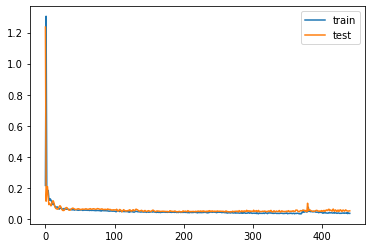

In [ ]:
# Loss Curve
import matplotlib.pyplot as plt
from matplotlib import pyplot
pyplot.plot(history.history['loss'][:], label='train')
pyplot.plot(history.history['val_loss'][:], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# prediction
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)

10/10 [==============================] - 0s 9ms/step


In [ ]:
# Evaluating the residual error using Nash-Sutcliffe and denormalization
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
inv_yhat_train = inv_yhat(yhat_train)
inv_yhat_test = inv_yhat(yhat_test)
inv_y_train = inv_y(y_train)
inv_y_test = inv_y(y_test)
print("train",nse(np.array(inv_yhat_train),np.array(inv_y_train)))
print("test",nse(np.array(inv_yhat_test),np.array(inv_y_test)))

train 0.3572978503601495
test 0.30366985850090067


In [ ]:
# Adding Simulated residual error in the data frame
df= pd.read_csv("/content/drive/MyDrive/Data/OneYearResidualErrorModelling.csv",index_col=0)
df=df[365:].reset_index(drop=True)
df.loc[:,"SimulatedResidualError"]=df.loc[:,"Residual Error"]
df.loc[365:,"SimulatedResidualError"]=inv_yhat_train+inv_yhat_test

In [ ]:
# Data Frame
df

,Date,Temperature (Deg C),Precipitation (mm),Observed Discharge (m3/s),Simulated Discharge (m3/s),Precipitation0816 (mm),Temperature0816 (Deg C),Residual Error,SimulatedResidualError
0,2004-01-01,12.50,0.0,53.1,349.32,0.0,6.00,-296.22,-296.220000
1,2004-01-02,12.20,0.0,52.4,361.22,0.0,6.50,-308.82,-308.820000
2,2004-01-03,12.25,0.0,51.3,177.82,0.0,5.00,-126.52,-126.520000
3,2004-01-04,12.25,0.0,50.3,175.16,6.0,5.25,-124.86,-124.860000
4,2004-01-05,13.50,0.0,49.6,167.70,0.0,7.00,-118.10,-118.100000
...,...,...,...,...,...,...,...,...,...
2552,2010-12-27,14.85,0.0,74.0,68.22,0.0,2.00,5.78,-17.427166
2553,2010-12-28,14.85,0.0,67.1,67.88,0.0,2.00,-0.78,-17.425109
2554,2010-12-29,15.50,0.0,67.9,67.54,0.0,2.20,0.36,-17.333495
2555,2010-12-30,15.60,0.0,64.3,67.20,0.0,2.50,-2.90,-17.119964


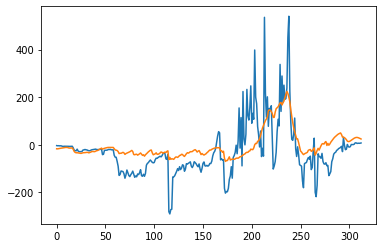

In [ ]:
# Training Plot
import matplotlib.pyplot as plt
plt.plot(inv_y_train[:])
plt.plot(inv_yhat_train[:])

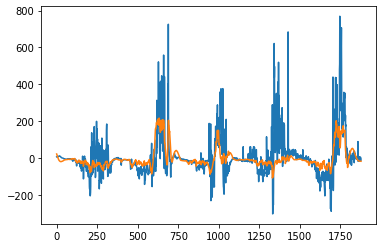

In [ ]:
# Testing Plot
import matplotlib.pyplot as plt
plt.plot(inv_y_test[:])
plt.plot(inv_yhat_test[:])

In [ ]:
# Adding Corrected Simulated discharge in the data frame
df[" Corrected Simulated Discharge (m3/s)"] = df["SimulatedResidualError"] + df["Simulated Discharge (m3/s)"]

In [ ]:
df

,Date,Temperature (Deg C),Precipitation (mm),Observed Discharge (m3/s),Simulated Discharge (m3/s),Precipitation0816 (mm),Temperature0816 (Deg C),Residual Error,SimulatedResidualError,Simulated Discharge (m3/s)
0,2008-01-02,14.60,0.0,55.5,62.32,0.0,6.00,-6.82,-14.890021,47.429979
1,2008-01-03,15.10,0.0,54.8,62.02,0.0,6.25,-7.22,-14.834976,47.185024
2,2008-01-04,14.15,0.0,54.1,61.72,0.0,5.25,-7.62,-14.978101,46.741899
3,2008-01-05,13.70,0.0,53.8,61.43,0.0,5.00,-7.63,-15.203296,46.226704
4,2008-01-06,10.85,0.0,53.1,61.14,0.0,5.25,-8.04,-15.985889,45.154111
...,...,...,...,...,...,...,...,...,...,...
1090,2010-12-27,14.85,0.0,74.0,68.22,0.0,2.00,5.78,-17.427166,50.792834
1091,2010-12-28,14.85,0.0,67.1,67.88,0.0,2.00,-0.78,-17.425109,50.454891
1092,2010-12-29,15.50,0.0,67.9,67.54,0.0,2.20,0.36,-17.333495,50.206505
1093,2010-12-30,15.60,0.0,64.3,67.20,0.0,2.50,-2.90,-17.119964,50.080036


In [ ]:
import plotly.express as px
px.line(df,"Date",["Observed Discharge (m3/s)"," Corrected Simulated Discharge (m3/s)"],labels={"value":"Discharge m3/s"},title="Nash Sutcliffe" +"\n" +"efficiency is 0.88")